In [0]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms, datasets

In [16]:
train_data = datasets.CIFAR10('CIFAR10', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

test_data = datasets.CIFAR10('CIFAR10', train = False,
                             transform = transforms.Compose([transforms.ToTensor()]),
                             download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)
test_batch = torch.utils.data.DataLoader(test_data, batch_size = 1, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size = (3, 3), stride = 1, padding = 1) #  32x32
        '''In the original paper the authors have drastically reduced the resolution of the image but since the image size here 
        is already very small therefore preserved the dimension in the first convolution operation'''
        self.conv2 = nn.Conv2d(96, 256, kernel_size = (3, 3), stride = 1, padding = 1) # 16x16
        self.conv3 = nn.Conv2d(256, 384, kernel_size = (3, 3), stride = 1, padding = 1) #8x8
        self.conv4 = nn.Conv2d(384, 384, kernel_size = (3, 3), stride = 1, padding = 1) #8x8
        self.conv5 = nn.Conv2d(384, 256, kernel_size = (3, 3), stride = 1, padding = 1) #8x8
        self.fc1 = nn.Linear(4096, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)
        
    def convs(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = (2, 2), stride = 2, padding = 0) # 16x16
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = (2, 2), stride = 2, padding = 0) # 8x8
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = (2, 2), stride = 2, padding = 0) #4x4
        return x
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 4096)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim = 1)
        return x
    
alexnet = AlexNet()

In [0]:
optimizer = optim.Adam(alexnet.parameters(), lr = 0.001)
loss_function = nn.BCELoss()

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")

Tesla P4


In [6]:
alexnet.to(device)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=10, bias=True)
)

In [0]:
def one_hot_encoder(labels, num_labels):
    batch_size = len(labels)
    one_hot_labels = torch.zeros([batch_size, num_labels])
    for i in range(batch_size):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

In [0]:
EPOCHS = 10

def train(train_batch):
    losses = np.zeros([EPOCHS, 500])
    for epoch in range(EPOCHS):
        INDEX = -1
        for images, labels in tqdm(train_batch):
            INDEX += 1
            one_hot_labels = one_hot_encoder(labels, 10)
            alexnet.zero_grad()
            outputs = alexnet.forward(images.to(device))
            loss = loss_function(outputs, (one_hot_labels).to(device))
            loss.backward()
            optimizer.step()
            losses[epoch][INDEX] = loss
        print(f"Epoch: {epoch} Loss: {loss}")
    return losses

In [0]:
def test(test_batch):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_batch):
            labels = labels.to(device)
            net_out = alexnet(images.to(device))
            predicted_class = torch.argmax(net_out).to(device)
            if (predicted_class == labels):
                correct += 1
            total += 1
        print("Accuracy: ", round(correct/total, 3))

In [10]:
losses = train(train_batch)

  0%|          | 2/500 [00:00<00:30, 16.51it/s]

Epoch: 0 Loss: 0.2633265256881714


  0%|          | 2/500 [00:00<00:30, 16.41it/s]

Epoch: 1 Loss: 0.20392508804798126


  0%|          | 2/500 [00:00<00:30, 16.52it/s]

Epoch: 2 Loss: 0.19147519767284393


  0%|          | 2/500 [00:00<00:30, 16.44it/s]

Epoch: 3 Loss: 0.18894104659557343


  0%|          | 2/500 [00:00<00:31, 15.60it/s]

Epoch: 4 Loss: 0.1452437937259674


  0%|          | 2/500 [00:00<00:31, 15.73it/s]

Epoch: 5 Loss: 0.13187003135681152


  0%|          | 2/500 [00:00<00:31, 15.85it/s]

Epoch: 6 Loss: 0.07402379810810089


  0%|          | 2/500 [00:00<00:31, 15.95it/s]

Epoch: 7 Loss: 0.07824160903692245


  0%|          | 2/500 [00:00<00:32, 15.19it/s]

Epoch: 8 Loss: 0.08062431216239929


100%|██████████| 500/500 [00:30<00:00, 16.39it/s]

Epoch: 9 Loss: 0.0825052261352539


In [11]:
test(test_batch)

100%|██████████| 10000/10000 [00:18<00:00, 550.95it/s]

Accuracy:  0.718


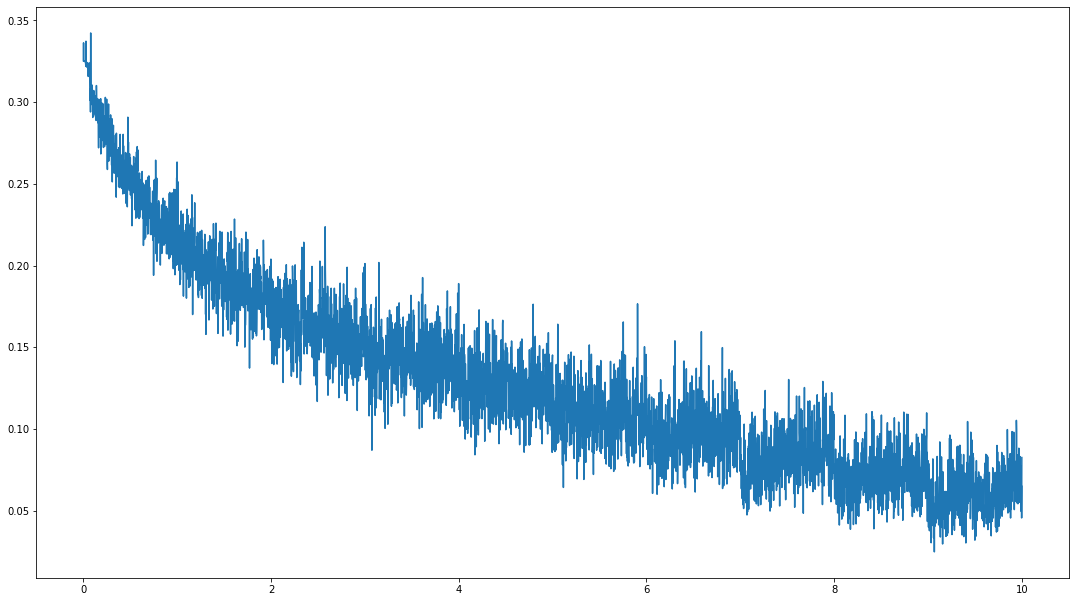

In [19]:
def plot_loss(losses):
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  x_label = np.linspace(0, 10 , num = 5000)
  y_label = np.reshape(losses, [5000,1])
  plt.plot(x_label, y_label)
  plt.show()

plot_loss(losses)